# Pairs Trading

In [55]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
import yfinance as yf
import seaborn
import matplotlib.pyplot as plt
from openbb_terminal.sdk import openbb
import networkx as nx
from scipy import stats


Getting Equities Data

In [4]:
ftse100_tickers = [
    "III.L", "ABF.L", "ADM.L", "AAL.L", "ANTO.L",
    "AHT.L", "AZN.L", "AUTO.L", "AV.L",
    "AV.L", "BA.L", "BARC.L", "BDEV.L", "BKG.L",
    "BHP.L", "BP.L", "BATS.L", "BLND.L", "BT-A.L",
    "BNZL.L", "BRBY.L", "CCH.L", "CPG.L", "CRH.L",
    "CRDA.L", "DCC.L", "DGE.L", "EVR.L", "EXPN.L",
    "FERG.L", "FLTR.L", "FRES.L", "GSK.L", "GLEN.L",
    "HLMA.L", "HL.L", "HMSO.L", "HSBA.L",
    "IMB.L", "INF.L", "IHG.L", "IAG.L", "ITRK.L",
    "ITV.L", "JD.L", "JMAT.L", "KGF.L", "LAND.L",
    "LGEN.L", "LLOY.L", "MNG.L", "MRO.L",
    "MNDI.L", "NG.L", "NXT.L", "OCDO.L",
    "PSON.L", "PSN.L", "PHNX.L", "POLY.L", "PRU.L",
    "REL.L", "RTO.L", "RIO.L", "RMV.L",
    "RR.L", "SGE.L",
    "SBRY.L", "SDR.L", "SMT.L", "SGRO.L", "SVT.L",
    "SN.L", "SMDS.L", "SMIN.L", "SKG.L", "SPX.L",
    "SSE.L", "STAN.L", "STJ.L", "TW.L",
    "TSCO.L", "TUI.L", "ULVR.L", "UU.L", "VOD.L",
    "WTB.L", "WPP.L"
]


In [5]:
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
data = yf.download(
    ftse100_tickers, 
    start='2022-10-01', 
    end='2023-09-03'
)['Adj Close']

[*********************100%%**********************]  87 of 87 completed


In [6]:
data.dropna(axis=1, inplace=True)

Checking for co-integration

In [7]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

<Axes: >

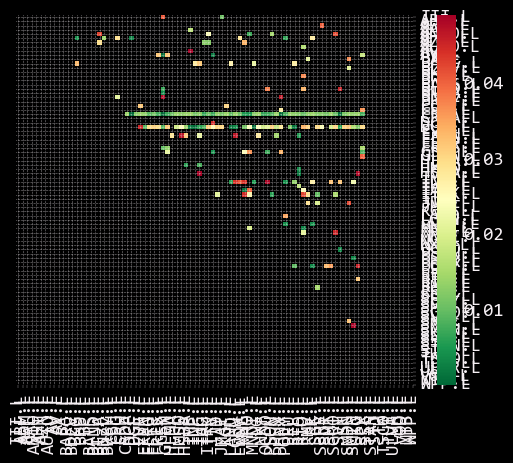

In [8]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
seaborn.heatmap(
    pvalues, 
    xticklabels=ftse100_tickers, 
    yticklabels=ftse100_tickers, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.05)
)

In [9]:
# Extract pairs where p-value is less than 0.05
pairs_to_consider = []
n = pvalues.shape[0]  # Assuming pvalues is a square matrix

for i in range(n):
    for j in range(i+1, n):
        if pvalues[i, j] >= 0.05:
            pairs_to_consider.append((ftse100_tickers[i], ftse100_tickers[j], pvalues[i, j]))

# Sort pairs by p-value
pairs_to_consider.sort(key=lambda x: x[2], reverse=True)

# Print the pairs
pairs_to_consider[:10]

[('NXT.L', 'PSN.L', 0.9939391039519712),
 ('NXT.L', 'RMV.L', 0.993894238155244),
 ('NXT.L', 'SKG.L', 0.9934861389159417),
 ('NXT.L', 'SMIN.L', 0.9934810611848588),
 ('NXT.L', 'RTO.L', 0.9925283614801961),
 ('PHNX.L', 'RMV.L', 0.9924498471633266),
 ('NXT.L', 'SMT.L', 0.9917154971273682),
 ('PHNX.L', 'SGE.L', 0.9896969368798905),
 ('ITV.L', 'RMV.L', 0.9880476282363556),
 ('NXT.L', 'SGE.L', 0.988045522711007)]

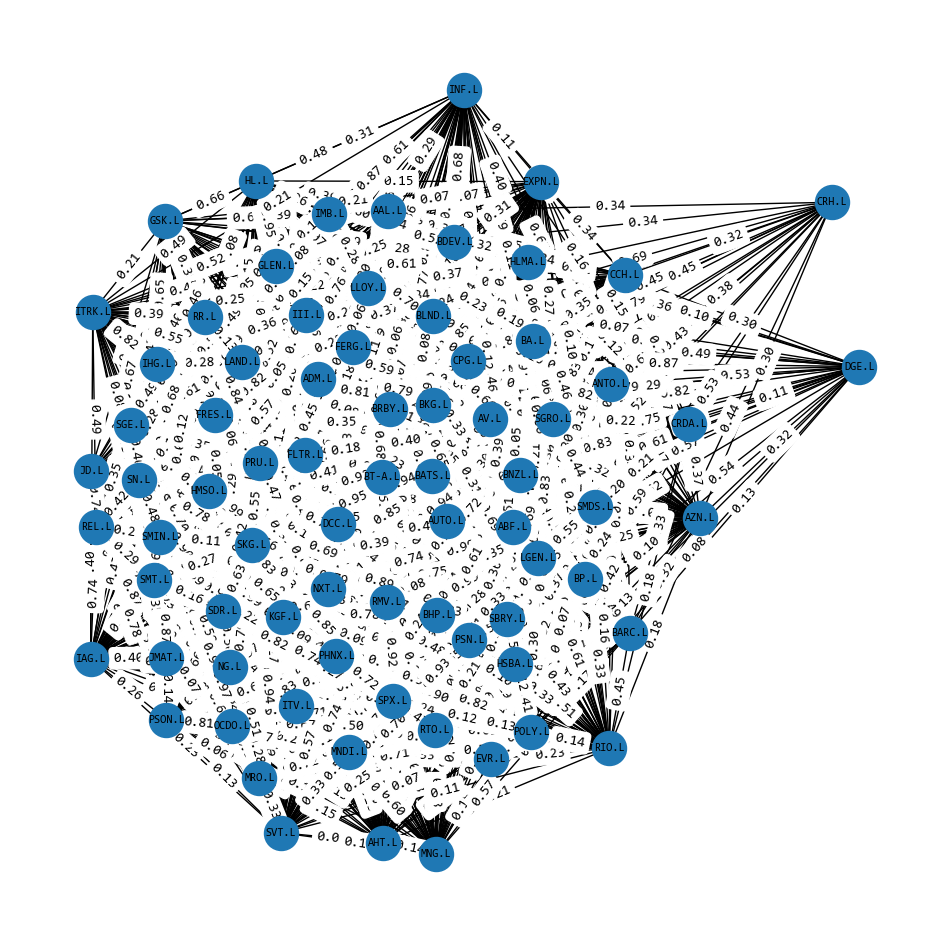

In [10]:
# Create a new graph
plt.figure(facecolor='white', figsize=(12, 12))
G = nx.Graph()

# Assuming pvalues is a square matrix
n = pvalues.shape[0]

# Add nodes
for ticker in ftse100_tickers[:n]:
    G.add_node(ticker)

# Add edges for significantly cointegrated pairs
for i in range(n):
    for j in range(i+1, n):
        if pvalues[i, j] >= 0.05:
            G.add_edge(ftse100_tickers[i], ftse100_tickers[j], weight=pvalues[i, j])

# Draw the graph with more spread-out nodes
# pos = nx.spring_layout(G, k=0.25)  # increasing k will spread nodes apart
pos = nx.spring_layout(G)  # increasing k will spread nodes apart

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=600)

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

# Draw labels for edges to show weight (p-value in this case)
edge_labels = {(n1, n2): f"{d['weight']:.2f}" for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.axis("off")
plt.show()

Top N Pairs:
  Ticker1 Ticker2   p-value
0   NXT.L   PSN.L  0.993939
1   NXT.L   RMV.L  0.993894
2   NXT.L   SKG.L  0.993486
3   NXT.L  SMIN.L  0.993481
4   NXT.L   RTO.L  0.992528
5  PHNX.L   RMV.L  0.992450
6   NXT.L   SMT.L  0.991715
7  PHNX.L   SGE.L  0.989697
8   ITV.L   RMV.L  0.988048
9   NXT.L   SGE.L  0.988046


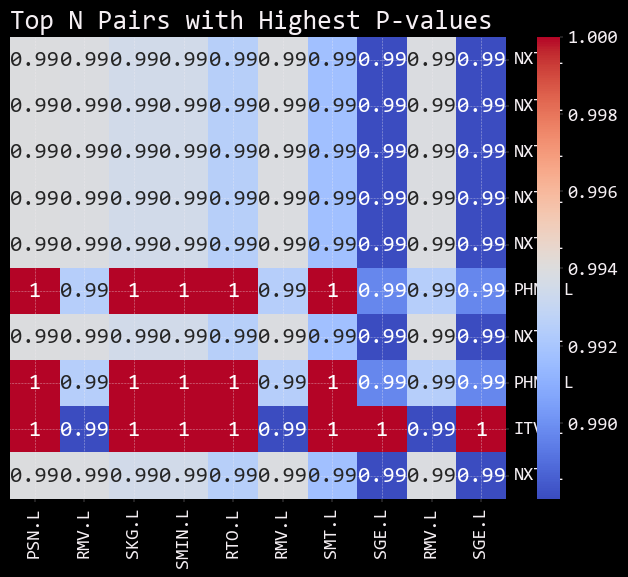

In [11]:
# Take the top N pairs (e.g., N=10)
top_n_pairs = pairs_to_consider[:10]

# Create a DataFrame to hold the top N pairs
df_top_n = pd.DataFrame(top_n_pairs, columns=['Ticker1', 'Ticker2', 'p-value'])

# Display the DataFrame
print("Top N Pairs:")
print(df_top_n)

# Create a smaller heatmap (or table) if you prefer
mini_matrix = pd.DataFrame(index=[x[0] for x in top_n_pairs], columns=[x[1] for x in top_n_pairs])

for ticker1, ticker2, p_value in top_n_pairs:
    mini_matrix.loc[ticker1, ticker2] = p_value

# Convert to float and fill NaNs
mini_matrix = mini_matrix.astype(float).fillna(1)

plt.figure(figsize=(8, 6))
seaborn.heatmap(mini_matrix, annot=True, cmap='coolwarm')
plt.title("Top N Pairs with Highest P-values")
plt.show()

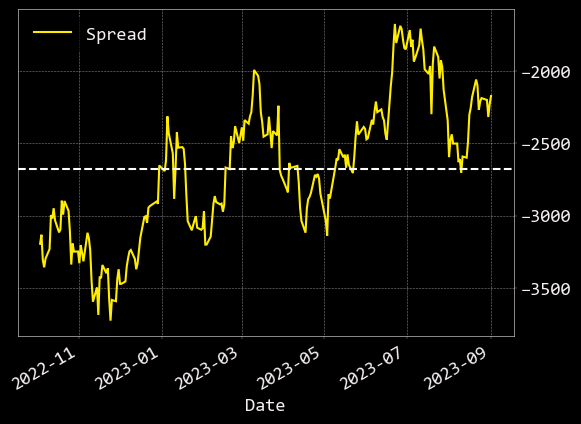

In [38]:
# Extract time series for RMV.L and NXT.L
S1 = data['RMV.L']
S2 = data['NXT.L']

# Add a constant term for intercept in the regression equation
S1_const = sm.add_constant(S1)
# Perform OLS regression
results = sm.OLS(S2, S1_const).fit()
# Extract the slope (beta coefficient)
b = results.params['RMV.L']
# Calculate the spread
spread = S2 - b * S1

# Plot the spread
spread.plot()
plt.axhline(spread.mean(), color='white', linestyle='--')
plt.legend(['Spread'])

In [40]:
S2

Date
2022-10-03    4685.087402
2022-10-04    4873.032715
2022-10-05    4613.395996
2022-10-06    4486.483887
2022-10-07    4317.914062
                 ...     
2023-08-25    6780.000000
2023-08-29    6958.000000
2023-08-30    6936.000000
2023-08-31    6988.000000
2023-09-01    7028.000000
Name: NXT.L, Length: 231, dtype: float64

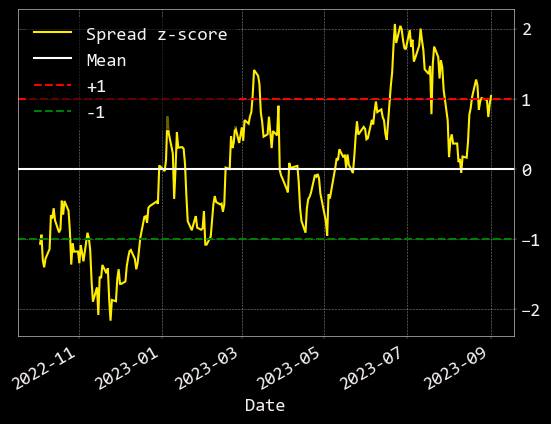

In [13]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='white')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [14]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

<Axes: xlabel='Date'>

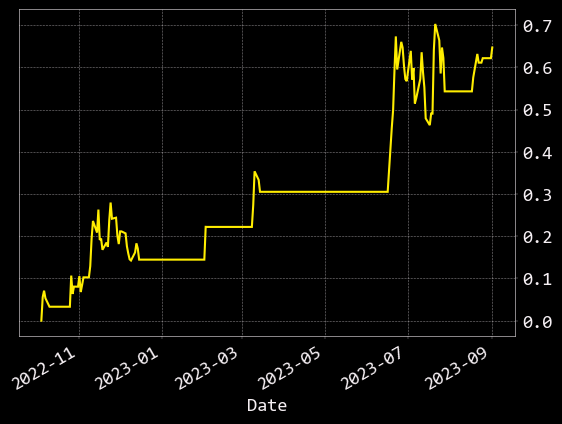

In [15]:
returns = trades.position.pct_change() * trades.side
returns.cumsum().plot()

Backtesting with Backtrader

In [16]:
import backtrader as bt

In [66]:
class PairTradingStrategy(bt.Strategy):
    params = dict(
        period=10
    )

    def __init__(self):
        self.data1 = self.datas[0]
        self.data2 = self.datas[1]
        self.order1 = None
        self.order2 = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def next(self):
        if len(self.data1) < self.params.period:
            return

        S1 = np.array([self.data1.close[-i] for i in range(1, self.params.period + 1)])
        S2 = np.array([self.data2.close[-i] for i in range(1, self.params.period + 1)])

        slope, intercept, r_value, p_value, std_err = stats.linregress(S1, S2)
        self.b = slope

        spread = S2 - self.b * S1
        zscore = (spread - np.mean(spread)) / np.std(spread)

        # self.log(f'Z-Score: {zscore[-1]}')

        if self.order1 or self.order2:
            return  # pending orders exist

        if zscore[-1] > 1:
            self.order1 = self.sell(data=self.data1)
            self.order2 = self.buy(data=self.data2)
        elif zscore[-1] < -1:
            self.order1 = self.buy(data=self.data1)
            self.order2 = self.sell(data=self.data2)

    # def notify_order(self, order):
    #     if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
    #         return

    #     if order.status in [bt.Order.Completed]:
    #         self.log(f'Order completed: {order.executed.price}, {order.executed.value}, {order.executed.size}')

    #     self.order1 = None
    #     self.order2 = None

In [89]:
S1_df = yf.download('RMV.L', start='2022-11-01', end='2023-09-01')
S2_df = yf.download('NXT.L', start='2022-11-01', end='2023-09-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [101]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()

    # Add strategy
    cerebro.addstrategy(PairTradingStrategy)

    # Create data feeds
    data1 = bt.feeds.PandasData(dataname=S1_df)
    data2 = bt.feeds.PandasData(dataname=S2_df)

    # Add data feeds to Cerebro
    cerebro.adddata(data1)
    cerebro.adddata(data2)

    # Set our desired cash start
    cerebro.broker.set_cash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.05)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Print percentage return
    pnl = cerebro.broker.getvalue() - 100000.0
    print(f'Return: {pnl * 100 / 100000.0}%')

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 109091.30
Return: 9.091300231933594%
